In [1]:
!pip install pytorch-metric-learning -q
!pip install faiss-gpu -q

     |████████████████████████████████| 109 kB 5.0 MB/s 
     |████████████████████████████████| 85.5 MB 101 kB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


In [3]:
mm = models.resnet18()

In [4]:
mm

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


device = torch.device("cuda")

img_mean, img_std = (0.1307,), (0.3081,)
normalize = transforms.Normalize(img_mean, img_std)
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

transform = transforms.Compose(
    [transforms.ToTensor(), normalize]
)

batch_size = 128

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)


num_classes = 128
# model = Net().to(device)

model = models.resnet18(True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0003)
num_epochs = 30


### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=128).to(device)
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [6]:
model.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

## Train the model

In [7]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 38.26390838623047
Epoch 1 Iteration 100: Loss = 4.073992729187012
Epoch 1 Iteration 200: Loss = 3.0347678661346436
Epoch 1 Iteration 300: Loss = 1.6131401062011719
Epoch 1 Iteration 400: Loss = 0.7508655786514282


100%|██████████| 313/313 [00:03<00:00, 84.11it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9765
Epoch 2 Iteration 0: Loss = 2.542907238006592
Epoch 2 Iteration 100: Loss = 1.2584431171417236
Epoch 2 Iteration 200: Loss = 1.0420310497283936
Epoch 2 Iteration 300: Loss = 3.7394800186157227
Epoch 2 Iteration 400: Loss = 1.290344476699829


100%|██████████| 313/313 [00:04<00:00, 66.17it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9836
Epoch 3 Iteration 0: Loss = 0.6019319295883179
Epoch 3 Iteration 100: Loss = 2.8813462257385254
Epoch 3 Iteration 200: Loss = 2.813687801361084
Epoch 3 Iteration 300: Loss = 2.1032261848449707
Epoch 3 Iteration 400: Loss = 0.354023277759552


100%|██████████| 313/313 [00:03<00:00, 83.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9843000000000001
Epoch 4 Iteration 0: Loss = 1.5719099044799805
Epoch 4 Iteration 100: Loss = 0.8760278820991516
Epoch 4 Iteration 200: Loss = 1.1250617504119873
Epoch 4 Iteration 300: Loss = 0.7199386358261108
Epoch 4 Iteration 400: Loss = 1.053807020187378


100%|██████████| 313/313 [00:03<00:00, 82.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9861000000000001
Epoch 5 Iteration 0: Loss = 0.5948464274406433
Epoch 5 Iteration 100: Loss = 1.1176276206970215
Epoch 5 Iteration 200: Loss = 1.4325451850891113
Epoch 5 Iteration 300: Loss = 1.8745887279510498
Epoch 5 Iteration 400: Loss = 2.240598440170288


100%|██████████| 313/313 [00:03<00:00, 82.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9878
Epoch 6 Iteration 0: Loss = 0.5940574407577515
Epoch 6 Iteration 100: Loss = 1.409285545349121
Epoch 6 Iteration 200: Loss = 0.29729163646698
Epoch 6 Iteration 300: Loss = 0.4726993441581726
Epoch 6 Iteration 400: Loss = 1.7925456762313843


100%|██████████| 313/313 [00:04<00:00, 68.80it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9875
Epoch 7 Iteration 0: Loss = 1.244807481765747
Epoch 7 Iteration 100: Loss = 1.0094099044799805
Epoch 7 Iteration 200: Loss = 0.6604769825935364
Epoch 7 Iteration 300: Loss = 0.8413553237915039
Epoch 7 Iteration 400: Loss = 0.8702431321144104


100%|██████████| 313/313 [00:03<00:00, 81.47it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9849
Epoch 8 Iteration 0: Loss = 0.7981561422348022
Epoch 8 Iteration 100: Loss = 0.8651257157325745
Epoch 8 Iteration 200: Loss = 1.8637069463729858
Epoch 8 Iteration 300: Loss = 1.2742853164672852
Epoch 8 Iteration 400: Loss = 0.4963769316673279


100%|██████████| 313/313 [00:03<00:00, 83.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9868
Epoch 9 Iteration 0: Loss = 0.7235715985298157
Epoch 9 Iteration 100: Loss = 0.9062474370002747
Epoch 9 Iteration 200: Loss = 1.0829378366470337
Epoch 9 Iteration 300: Loss = 0.8232119083404541
Epoch 9 Iteration 400: Loss = 0.046573977917432785


100%|██████████| 313/313 [00:03<00:00, 83.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9867
Epoch 10 Iteration 0: Loss = 0.5705074071884155
Epoch 10 Iteration 100: Loss = 0.976719081401825
Epoch 10 Iteration 200: Loss = 0.8801989555358887
Epoch 10 Iteration 300: Loss = 0.7893615961074829
Epoch 10 Iteration 400: Loss = 0.15836088359355927


100%|██████████| 313/313 [00:03<00:00, 83.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9866
Epoch 11 Iteration 0: Loss = 0.9113214015960693
Epoch 11 Iteration 100: Loss = 0.7598089575767517
Epoch 11 Iteration 200: Loss = 0.9218560457229614
Epoch 11 Iteration 300: Loss = 0.028159139677882195
Epoch 11 Iteration 400: Loss = 0.8821321725845337


100%|██████████| 313/313 [00:03<00:00, 83.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9903000000000001
Epoch 12 Iteration 0: Loss = 0.8225971460342407
Epoch 12 Iteration 100: Loss = 0.024230079725384712
Epoch 12 Iteration 200: Loss = 0.7124536037445068
Epoch 12 Iteration 300: Loss = 0.062042515724897385
Epoch 12 Iteration 400: Loss = 0.9829053282737732


100%|██████████| 313/313 [00:03<00:00, 82.10it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9878
Epoch 13 Iteration 0: Loss = 0.6012808680534363
Epoch 13 Iteration 100: Loss = 0.5155186057090759
Epoch 13 Iteration 200: Loss = 0.5655403733253479
Epoch 13 Iteration 300: Loss = 0.4496280252933502
Epoch 13 Iteration 400: Loss = 0.021411152556538582


100%|██████████| 313/313 [00:03<00:00, 82.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9887
Epoch 14 Iteration 0: Loss = 0.5417630076408386
Epoch 14 Iteration 100: Loss = 1.2872743606567383
Epoch 14 Iteration 200: Loss = 0.2082715481519699
Epoch 14 Iteration 300: Loss = 1.4042268991470337
Epoch 14 Iteration 400: Loss = 0.001545189181342721


100%|██████████| 313/313 [00:03<00:00, 82.49it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9895
Epoch 15 Iteration 0: Loss = 0.5627773404121399
Epoch 15 Iteration 100: Loss = 0.0018082552123814821
Epoch 15 Iteration 200: Loss = 0.0024913952220231295
Epoch 15 Iteration 300: Loss = 0.6114349365234375
Epoch 15 Iteration 400: Loss = 0.0005474629579111934


100%|██████████| 313/313 [00:03<00:00, 82.98it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9899
Epoch 16 Iteration 0: Loss = 0.5239994525909424
Epoch 16 Iteration 100: Loss = 0.3952004313468933
Epoch 16 Iteration 200: Loss = 1.0425708293914795
Epoch 16 Iteration 300: Loss = 0.10699393600225449
Epoch 16 Iteration 400: Loss = 0.5175360441207886


100%|██████████| 313/313 [00:03<00:00, 83.73it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9906
Epoch 17 Iteration 0: Loss = 9.099077578866854e-05
Epoch 17 Iteration 100: Loss = 0.0993625670671463
Epoch 17 Iteration 200: Loss = 0.9989224076271057
Epoch 17 Iteration 300: Loss = 0.7340081930160522
Epoch 17 Iteration 400: Loss = 0.8680981397628784


100%|██████████| 313/313 [00:03<00:00, 83.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9896
Epoch 18 Iteration 0: Loss = 0.0012502206955105066
Epoch 18 Iteration 100: Loss = 0.03697292134165764
Epoch 18 Iteration 200: Loss = 0.005120022222399712
Epoch 18 Iteration 300: Loss = 0.00018421433924231678
Epoch 18 Iteration 400: Loss = 0.005205432418733835


100%|██████████| 313/313 [00:03<00:00, 83.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9903000000000001
Epoch 19 Iteration 0: Loss = 0.02241906151175499
Epoch 19 Iteration 100: Loss = 0.8113867044448853
Epoch 19 Iteration 200: Loss = 0.25937917828559875
Epoch 19 Iteration 300: Loss = 0.0075789871625602245
Epoch 19 Iteration 400: Loss = 0.688046932220459


100%|██████████| 313/313 [00:03<00:00, 84.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9918
Epoch 20 Iteration 0: Loss = 0.012007910758256912
Epoch 20 Iteration 100: Loss = 0.5596750378608704
Epoch 20 Iteration 200: Loss = 0.8875715136528015
Epoch 20 Iteration 300: Loss = 0.0047884052619338036
Epoch 20 Iteration 400: Loss = 1.1045167446136475


100%|██████████| 313/313 [00:03<00:00, 82.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9907
Epoch 21 Iteration 0: Loss = 1.0973058938980103
Epoch 21 Iteration 100: Loss = 1.3960093259811401
Epoch 21 Iteration 200: Loss = 0.004607539623975754
Epoch 21 Iteration 300: Loss = 1.2606045007705688
Epoch 21 Iteration 400: Loss = 7.597639341838658e-05


100%|██████████| 313/313 [00:03<00:00, 82.74it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.991
Epoch 22 Iteration 0: Loss = 0.7473225593566895
Epoch 22 Iteration 100: Loss = 0.8475505113601685
Epoch 22 Iteration 200: Loss = 1.0215022563934326
Epoch 22 Iteration 300: Loss = 0.4008153975009918
Epoch 22 Iteration 400: Loss = 0.7162558436393738


100%|██████████| 313/313 [00:03<00:00, 83.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9912000000000001
Epoch 23 Iteration 0: Loss = 0.0009477459825575352
Epoch 23 Iteration 100: Loss = 1.3420733213424683
Epoch 23 Iteration 200: Loss = 0.4860915243625641
Epoch 23 Iteration 300: Loss = 0.00031444476917386055
Epoch 23 Iteration 400: Loss = 1.5853703022003174


100%|██████████| 313/313 [00:03<00:00, 83.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9911000000000001
Epoch 24 Iteration 0: Loss = 0.0012260458897799253
Epoch 24 Iteration 100: Loss = 0.0017899363301694393
Epoch 24 Iteration 200: Loss = 0.0007449156837537885
Epoch 24 Iteration 300: Loss = 0.07040457427501678
Epoch 24 Iteration 400: Loss = 0.0015334601048380136


100%|██████████| 313/313 [00:03<00:00, 83.81it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9906
Epoch 25 Iteration 0: Loss = 0.0009042865131050348
Epoch 25 Iteration 100: Loss = 0.48977866768836975
Epoch 25 Iteration 200: Loss = 0.000674189068377018
Epoch 25 Iteration 300: Loss = 0.0003427889896556735
Epoch 25 Iteration 400: Loss = 0.30992382764816284


100%|██████████| 313/313 [00:03<00:00, 83.77it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9903000000000001
Epoch 26 Iteration 0: Loss = 0.9731197357177734
Epoch 26 Iteration 100: Loss = 0.45187798142433167
Epoch 26 Iteration 200: Loss = 0.08399460464715958
Epoch 26 Iteration 300: Loss = 0.0009246538393199444
Epoch 26 Iteration 400: Loss = 0.5630584359169006


100%|██████████| 313/313 [00:03<00:00, 82.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9919
Epoch 27 Iteration 0: Loss = 0.2365921586751938
Epoch 27 Iteration 100: Loss = 0.0014536399394273758
Epoch 27 Iteration 200: Loss = 0.0005655820714309812
Epoch 27 Iteration 300: Loss = 0.00014207357889972627
Epoch 27 Iteration 400: Loss = 0.15375307202339172


100%|██████████| 313/313 [00:03<00:00, 85.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9914000000000001
Epoch 28 Iteration 0: Loss = 0.0004906285903416574
Epoch 28 Iteration 100: Loss = 0.0018511521629989147
Epoch 28 Iteration 200: Loss = 0.701060950756073
Epoch 28 Iteration 300: Loss = 0.0478140227496624
Epoch 28 Iteration 400: Loss = 0.05100463330745697


100%|██████████| 313/313 [00:03<00:00, 83.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.992
Epoch 29 Iteration 0: Loss = 0.5305541157722473
Epoch 29 Iteration 100: Loss = 1.0712363719940186
Epoch 29 Iteration 200: Loss = 0.006510147824883461
Epoch 29 Iteration 300: Loss = 0.5593326687812805
Epoch 29 Iteration 400: Loss = 0.0010918432381004095


100%|██████████| 313/313 [00:03<00:00, 83.65it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9925
Epoch 30 Iteration 0: Loss = 0.5275094509124756
Epoch 30 Iteration 100: Loss = 0.0005841952515766025
Epoch 30 Iteration 200: Loss = 0.002161781769245863
Epoch 30 Iteration 300: Loss = 0.025393402203917503
Epoch 30 Iteration 400: Loss = 0.0016339438734576106


100%|██████████| 313/313 [00:03<00:00, 82.77it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9924000000000001


## Get outliers

In [8]:
train_embeddings, train_labels = get_all_embeddings(dataset1, model)

100%|██████████| 1875/1875 [00:22<00:00, 83.99it/s]


In [9]:
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1))
print(f"There are {len(outliers)} outliers")

There are 99 outliers


## View some sample outliers

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(img_mean, img_std)], std=[1 / s for s in img_std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_many(dataset, outliers, n=32):
    imgs = [
        dataset[outliers[i]][0]
        for i in np.random.choice(
            len(outliers), size=min(n, len(outliers)), replace=False
        )
    ]
    imshow(torchvision.utils.make_grid(imgs))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


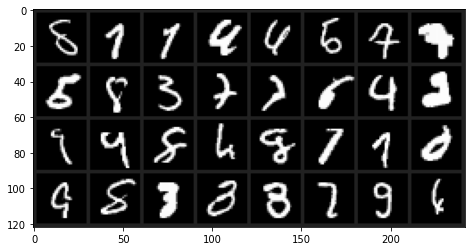

In [11]:
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers
imshow_many(dataset1, outliers)